In [71]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.primitives import Estimator
from qiskit.algorithms.gradients import ParamShiftEstimatorGradient
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes, EfficientSU2
from qiskit.quantum_info import Clifford

In [68]:
def heisenberg_model(num_sites=3, J=0.25, g=-1, reps=1):
    interactions = (
        [("XX", [i, i + 1], J) for i in range(num_sites - 1)]
        + [("YY", [i, i + 1], J) for i in range(num_sites - 1)]
        + [("ZZ", [i, i + 1], J) for i in range(num_sites - 1)]
    )
    field = [("Z", [i], g) for i in range(num_sites)]
    spo = SparsePauliOp.from_sparse_list(interactions + field, num_sites)

    circuit = EfficientSU2(num_sites, reps=reps, entanglement="pairwise")
    return spo, circuit

In [84]:
def zz_model(num_sites=3, reps=1, local=False):
    # you can also exchange this for a local operator and observe the same!
    if local:
        operator = SparsePauliOp.from_sparse_list([("ZZ", [0, 1], 1)], num_qubits=num_sites)
    else:
        operator = SparsePauliOp(["Z" * num_qubits])
    
    # real amplitudes ansatz
    ansatz = RealAmplitudes(num_sites, entanglement="linear", reps=reps)

    return operator, ansatz

In [82]:
def sample_gradients(num_qubits, reps, local=False, clifford=False, heisenberg=False):
    """Sample the gradient of our model for ``num_qubits`` qubits and ``reps`` repetitions.
    
    We sample 100 times for random parameters and compute the gradient of the first RY rotation gate.
    """
    index = num_qubits - 1
    
    if heisenberg:
        operator, ansatz = heisenberg_model(num_qubits, reps=reps)
    else:
        operator, ansatz = zz_model(num_qubits, reps=reps, local=local)

    # construct Gradient we want to evaluate for different values
    estimator = Estimator()
    grad = ParamShiftEstimatorGradient(estimator)
    
    # evaluate for 100 different, random parameter values
    num_points = 100
    points = []

    for _ in range(num_points):
        # points are uniformly chosen from [0, pi]
        if clifford:
            point = np.random.choice([0, np.pi/2, np.pi, 3 * np.pi / 2], ansatz.num_parameters)
        else:
            point = np.random.uniform(0, 2 * np.pi, ansatz.num_parameters)
            
        points.append(point)

    grads = grad.run(
        num_points * [ansatz], 
        num_points * [operator], 
        points, 
        parameters=num_points * [[ansatz.parameters[index]]]
    ).result() 
    return grads.gradients

## Global ZZ

In [91]:
num_qubits = list(range(2, 10))
reps = num_qubits  # number of layers = numbers of qubits
gradients = [sample_gradients(n, r) for n, r in zip(num_qubits, reps)]  

In [33]:
gradients = np.reshape(gradients, (len(num_qubits), 100))

In [62]:
num_qubits = list(range(2, 10))
reps = num_qubits  # number of layers = numbers of qubits
clifford_gradients = [sample_gradients(n, r, clifford=True) for n, r in zip(num_qubits, reps)]  

In [64]:
clifford_gradients = np.reshape(clifford_gradients, (len(num_qubits), 200))

In [90]:
clifford_gradients.shape

(8, 200)

(0.001, 10.004086265495452)

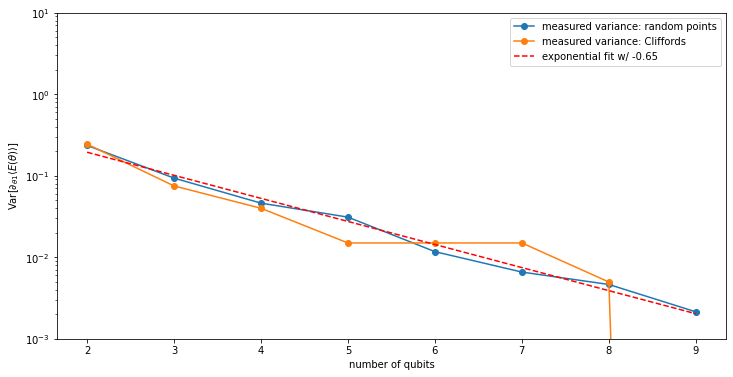

In [93]:
fit = np.polyfit(num_qubits, np.log(np.var(gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-', label='measured variance: random points')
plt.semilogy(num_qubits, np.var(clifford_gradients, axis=1), 'o-', label='measured variance: Cliffords')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');
plt.ylim(bottom=1e-3)

## Heisenberg

In [85]:
num_qubits = list(range(2, 13))
reps = num_qubits  # number of layers = numbers of qubits
local = [sample_gradients(n, r, local=True) for n, r in zip(num_qubits, reps)]  

In [75]:
num_qubits = list(range(2, 13))
reps = num_qubits  # number of layers = numbers of qubits
heisen = [sample_gradients(n, r, heisenberg=True) for n, r in zip(num_qubits, reps)]  

In [76]:
heisen = np.reshape(heisen, (len(num_qubits), 100))

(0.001, 0.5754125367569796)

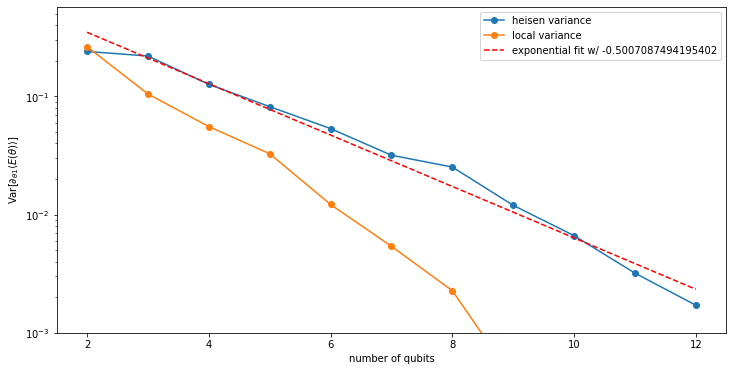

In [86]:
fit = np.polyfit(num_qubits, np.log(np.var(heisen, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(heisen, axis=1), 'o-', label='heisen variance')
plt.semilogy(num_qubits, np.var(local, axis=1), 'o-', label='local variance')
# plt.semilogy(num_qubits, np.var(clifford_gradients, axis=1), 'o-', label='measured variance')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {fit[0]}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');
plt.ylim(bottom=1e-3)

In [ ]:
num_qubits = list(range(2, 10))
reps = num_qubits  # number of layers = numbers of qubits
clifford_gradients = [sample_gradients(n, r, clifford=True) for n, r in zip(num_qubits, reps)]  